In [1]:
from ROOT import TCanvas, TGraph, TH1F, TF1, TRandom3,TFile, gPad, TLegend, gROOT, gStyle, TH2F, TGraphErrors, TLatex
from array import array
import pandas as pd
import numpy as np
import math

Welcome to JupyROOT 6.26/06


Creamos un Array que contenga los elementos los parametros que se van a ocupar para cada analisis.

Isotopo = [file.mca, isotopo, energia, canalinicial, canalfinal, p0, p1, p2, p3, p4, Canvas_title]

Primer analisis de los datos con ROOT
p0 = Norma
p1 = mean
p2 = sigma
p3 = pendiente
p4 = ordenada al origen 

In [58]:
Co60 =   ["20221021_Co60_g3_7200s_th1.mca", "Co60", 1173, 3942, 3953, 24431, 3947, 2.60, 0, 2.91, "Peak ^{60}Co #rightarrow 1173 [keV]"]
Co60_2 = ["20221021_Co60_g3_7200s_th1.mca", "Co60", 1332, 4479, 4490, 20084, 4484, 2.65, 0, 9.77, "Peak ^{60}Co #rightarrow 1332 [keV]"]
Na22 =   ["20221025_Na22_g3_7200s.mca", "Na22", 511, 1710, 1727, 87078, 1718, 3.72, 0, 2.87, "Peak ^{22}Na #rightarrow 511 [keV]"] 


datos = [Co60, Co60_2, Na22]

datos = pd.read_csv('datanalysis.csv', sep=',').to_numpy()

isotopes = {}                #Empty dictionary
name = ''


#print(datos, isotopes)

Corremos el analisis de los datos con ROOT

p0 = -31.68377185347456
p1 = 142239.87076442305
errmean = 0.021908479396758836
norm = 20084.097475421717
mean = 4484.406066884811
sigm = 2.648035239191988
slop = -31.68377185347456
cons = 142239.87076442305
chi2/ndof = 3.07032279453962/7 = 0.43861754207708853
Prob = 0.8784214486480311
 FCN=3.07032 FROM HESSE     STATUS=NOT POSDEF     31 CALLS         293 TOTAL
                     EDM=1.68559e-07    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.00841e+04   8.04778e+02   2.83049e-02  -7.92724e-07
   2  p1           4.48441e+03   2.19085e-02   1.06917e-03  -1.90789e-02
   3  p2           2.64804e+00   6.65989e-02   3.92268e-06   1.79832e-02
   4  p3          -3.16838e+01   3.22085e-02   7.55400e-06   3.86016e-02
   5  p4           1.42240e+05   1.44538e+02   3.39126e-02   8.65188e-06


Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hz (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_frame (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file Peak Co60 g3 1332 keV.pdf has been created


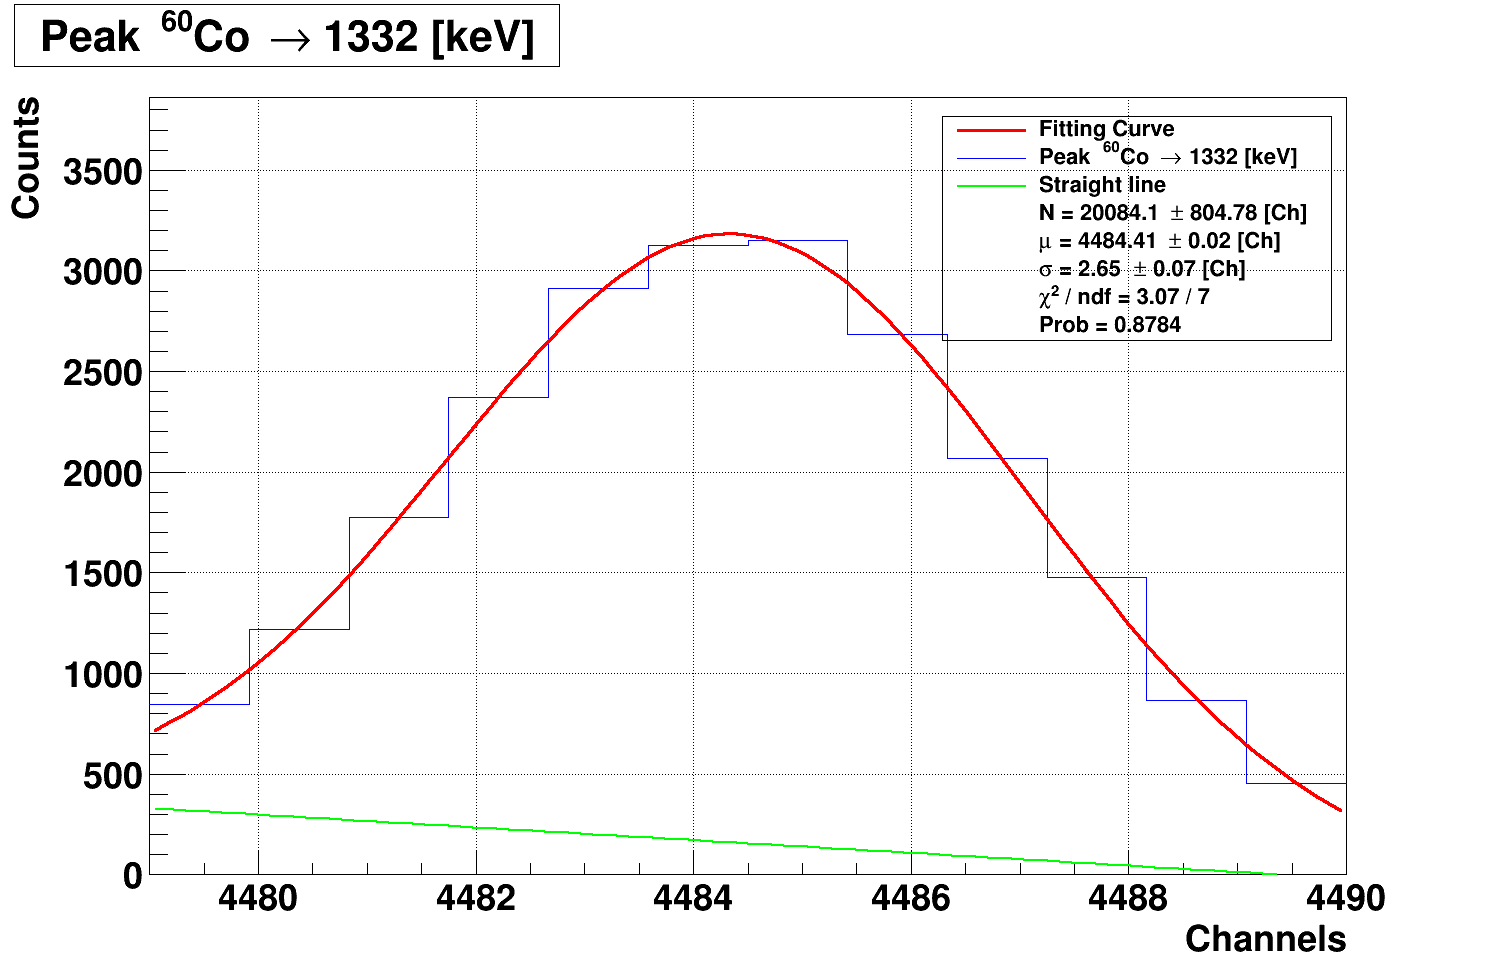

In [66]:
# #carga los datos del espectro en la variable "data"
n = 8192

x=array('d')
for i in range(0,8192):
    x.append(i)

#espectro=open('../20221013_10h_th15kev_bkgd.mca','r',encoding="ISO-8859-15")
espectro=open('./' + Co60_2[0],'r',encoding="ISO-8859-15")
data=array('d')
saveFlag=False

for line in espectro: 
    if saveFlag==True:
        if line.startswith('<<END>>'):
            saveFlag=False
        else:
            data.append(int(line))
    
    elif line.startswith('<<DATA>>'):
        saveFlag=True
    
    else:
        continue

m = max(data)

#############

#define histogram
#histograma 1, el espectro completo
h = TH1F("h","Full",n,0,n) #parametros del histograma, de todo el espectro. Va de 0 a 8192

#histograma 2, el pico entre los canales 2830 y 2890
lo = Co60_2[3]       #indices del histograma del pico
hi = Co60_2[4]    #el espectro va de 1 a 8192, el pico que vamos a analizar comienza esta entre "lo"y "hi"
bins = hi-lo +1   #nùmero de bins en el Histograma 
hz = TH1F("hz","",bins,lo,hi) #definimos hz como el histograma del pico
hz.GetXaxis().SetTitle("Channels")
hz.GetYaxis().SetTitle("Counts")

for i in range(0,n): #en este for crea ambos histogramas. h, el espectro total; hz, el del pico
    h.SetBinContent(i+1,data[i]) #deposita el contenido del array en el histograma, 
    if i in range(lo,hi+1):      #bin a bin utilizando SetBinContent
        hz.SetBinContent(i-lo+1,data[i]) #define el rango entre "lo" y "hi"
                                        #y lo llenamos utilizando un for:

#Fit Gaussian + base line to peak histogram
#definimos la curva
# ft = curva gausiana que queremos ajustar y una linea con pendiente 0 y ordenada al origen 5 (background) 
fT = TF1("fT","[0]*(1/sqrt(2*3.14159*[2]^2)*exp(-0.5*((x-[1])/[2])^2))+ ([3]*x+[4])",lo,hi)
#establecemos unos valores iniciales de cada parametro, 
#fT.SetParameters(254.84,1368.44,4.8975,0,5) 
fT.SetParameters( Co60_2[5], Co60_2[6] , Co60_2[7], Co60_2[8] , Co60_2[9])
# ajustamos la curva ft al histograma hz
hz.Fit(fT,"R")

norm = fT.GetParameter(0)   ############
mean = fT.GetParameter(1)   # Parametros de la Gaussiana
sigm = fT.GetParameter(2)   # devuelve los valores y podemos 
slop = fT.GetParameter(3)   # almacenarlos para manipularlos despues
cons = fT.GetParameter(4)   ############

chi2 = fT.GetChisquare()    ###
ndof = fT.GetNDF()          #datos de la calidad del ajuste
Prob = fT.GetProb()         ###
adjust = chi2/ndof          #Calidad del ajuste, si es cercano a 1, es bueno 

errenorm = fT.GetParError(0) #Obtiene el error del parametro 0
errmean  = fT.GetParError(1) #Obtiene el error del parametro 1
errsig   = fT.GetParError(2) #Obtiene el error del parametro 2
erreslop = fT.GetParError(3) #Obtiene el error del parametro 2
errecons = fT.GetParError(4) #Obtiene el error del parametro 2



#Creamos una TF1 que sea una linea recta y la podamos graficar en el mismo TCanvas 
line = TF1("line", "[0]*x+[1]", lo, hi)
line.SetParameters(slop, cons)

print("p0 = " + str(line.GetParameter(0)))
print("p1 = " + str(line.GetParameter(1)))


print("errmean = " + str(errmean))
print("norm = "+ str(norm))
print("mean = "+ str(mean))
print("sigm = "+ str(sigm))
print("slop = "+ str(slop))
print("cons = "+ str(cons))
print("chi2/ndof = "+ str(chi2)+"/"+str(ndof) + " = " + str(adjust) )
print("Prob = "+ str(Prob))

#Creamos un nuevo Canvas con los datos del ajuste e imprimimos el nuevo Canvas 

#-----Creamos strings para los nombres que vamos a usar en la clase TLegend-----
Normname  = "N = " + str(round(norm, 2)) + " #pm " + str(round(errenorm,2)) + " [Ch]"
meanname  = "#mu = " + str(round(mean, 2)) + " #pm " + str(round(errmean,2)) + " [Ch]"
sigmname  = "#sigma = " + str(round(sigm, 2)) + " #pm " + str(round(errsig,2)) + " [Ch]"
chiname   = "#chi^{2} / ndf = " + str(round(chi2, 2)) + " / " + str(ndof) 
probname  = "Prob = " + str(round(Prob, 4))
Framename = Co60_2[10] + "; Channels; Counts"
PrintName = "Peak " + Co60_2[1] + " g3 " + str(Co60_2[2]) + " keV.pdf" 


#-----Se crean las leyendas que a parecen en el Canvas con los datos del ajuste y su probabilidad---
leg = TLegend(0.63,0.88,0.89,0.65)
leg.SetFillStyle(0)
leg.SetBorderSize(1)
leg.SetTextSize(0.025)
leg.AddEntry(fT,"Fitting Curve","l")
leg.AddEntry(hz, Co60_2[10],"l")
leg.AddEntry(line, "Straight line", "l")
leg.AddEntry(0, Normname , "")
leg.AddEntry(0, meanname , "")
leg.AddEntry(0, sigmname , "")
leg.AddEntry(0, chiname , "")
leg.AddEntry(0, probname, "")


hist_frame = TH2F("hist_frame", Framename ,1,lo,hi, 1, 0, m+100)
hist_frame.GetYaxis().SetTitleOffset(1.3)

c1 = TCanvas( 'c1', '', 300, 500, 1500, 1000 ) #(puntos en x,puntos en y, size (X,y))

#c1.SetFillColor( 42 )
c1.SetGrid()
#---------Style-----------
gROOT.SetStyle("Plain")
gStyle.SetOptStat(0)
#gPad.SetLogy(1)  #set the canvas in a log mode in y
#---------Style-----------

#----Set color to the lines----
fT.SetLineColor(2)
hz.SetLineColor(4)
line.SetLineColor(3)

#----Set Width to the lines-----
line.SetLineWidth(2)

c1.Draw()
hist_frame.Draw()
line.Draw("same")
hz.Draw("same")
fT.Draw("same")
leg.Draw()

c1.Print(PrintName)



In [ ]:
name = ''

Creamos un diccionario con los datos obtenidos de los ajustes 

In [83]:

parameters = {'Norm' : str(round(norm,4))+" ± "+str(round(errenorm,4)), 
             'Mean' : str(round(mean,4))+" ± "+str(round(errmean,4)),
             'StdDev' : str(round(sigm,4))+" ± "+str(round(errsig,4)),
             'Slop' : str(round(slop,4))+" ± "+str(round(erreslop,4)),
             'Cons' : str(round(cons,4))+" ± "+str(round(errecons)),
             'Chi2 / NDF' : str(round(chi2,4))+' / '+str(ndof),
             'Prob' : str(round(Prob,4))
             }

peak = {str(Co60_2[2]): parameters}


if Co60[1] in isotopes:
    if Co60[1] == name:
        #peak = {str(Co60[2]): parameters}
        isotopes[name][str(Co60[2])]  = parameters
    else:
        isotopes[Co60_2[1]] = peak
else:
    isotopes[Co60[1]] = peak
    name = Co60[1]



#print(Co60[1])

In [74]:
print(isotopes)

{'Co60': {'1332': {'Norm': '20084.0975 ± 804.7776', 'Mean': '4484.4061 ± 0.0219', 'StdDev': '2.648 ± 0.0666', 'Slop': '-31.6838 ± 0.0322', 'Cons': '142239.8708 ± 145', 'Chi2 / NDF': '3.0703 / 7', 'Prob': '0.8784'}, '1173': {'Norm': '20084.0975 ± 804.7776', 'Mean': '4484.4061 ± 0.0219', 'StdDev': '2.648 ± 0.0666', 'Slop': '-31.6838 ± 0.0322', 'Cons': '142239.8708 ± 145', 'Chi2 / NDF': '3.0703 / 7', 'Prob': '0.8784'}}, 'Na22': {'1332': {'Norm': '20084.0975 ± 804.7776', 'Mean': '4484.4061 ± 0.0219', 'StdDev': '2.648 ± 0.0666', 'Slop': '-31.6838 ± 0.0322', 'Cons': '142239.8708 ± 145', 'Chi2 / NDF': '3.0703 / 7', 'Prob': '0.8784'}}}


El analisis anterior lo metemos en un for para iterar en una lista de datos, que contienen los datos del ajuste. 

p0 = -25.31815183861237
p1 = 99997.92487095068
errmean = 0.019157799205423987
norm = 24358.619878424062
mean = 3947.946175994799
sigm = 2.6246204234040853
slop = -25.31815183861237
cons = 99997.92487095068
chi2/ndof = 7.782101431530097/7 = 1.111728775932871
Prob = 0.3521997089564109
p0 = -31.68377185347456
p1 = 142239.87076442305
errmean = 0.021908479396758836
norm = 20084.097475421717
mean = 4484.406066884811
sigm = 2.648035239191988
slop = -31.68377185347456
cons = 142239.87076442305
chi2/ndof = 3.07032279453962/7 = 0.43861754207708853
Prob = 0.8784214486480311
p0 = -3.787771175919939
p1 = 7011.511947168365
errmean = 0.02125823134459128
norm = 80086.77761023898
mean = 1718.404471103374
sigm = 3.481590223128318
slop = -3.787771175919939
cons = 7011.511947168365
chi2/ndof = 12.267769145418734/13 = 0.9436745496475949
Prob = 0.50581855981891
p0 = -15.810336707887073
p1 = 67775.2132750869
errmean = 0.022094899074299474
norm = 17896.610831805778
mean = 4288.761268607873
sigm = 2.8696391640

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file Peak Co60 g3 1173.0 keV.pdf has been created
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hz (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_frame (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file Peak Co60 g3 1332.0 keV.pdf has been created
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hz (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_frame (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file Peak Na22 g3 511.0 keV.pdf ha

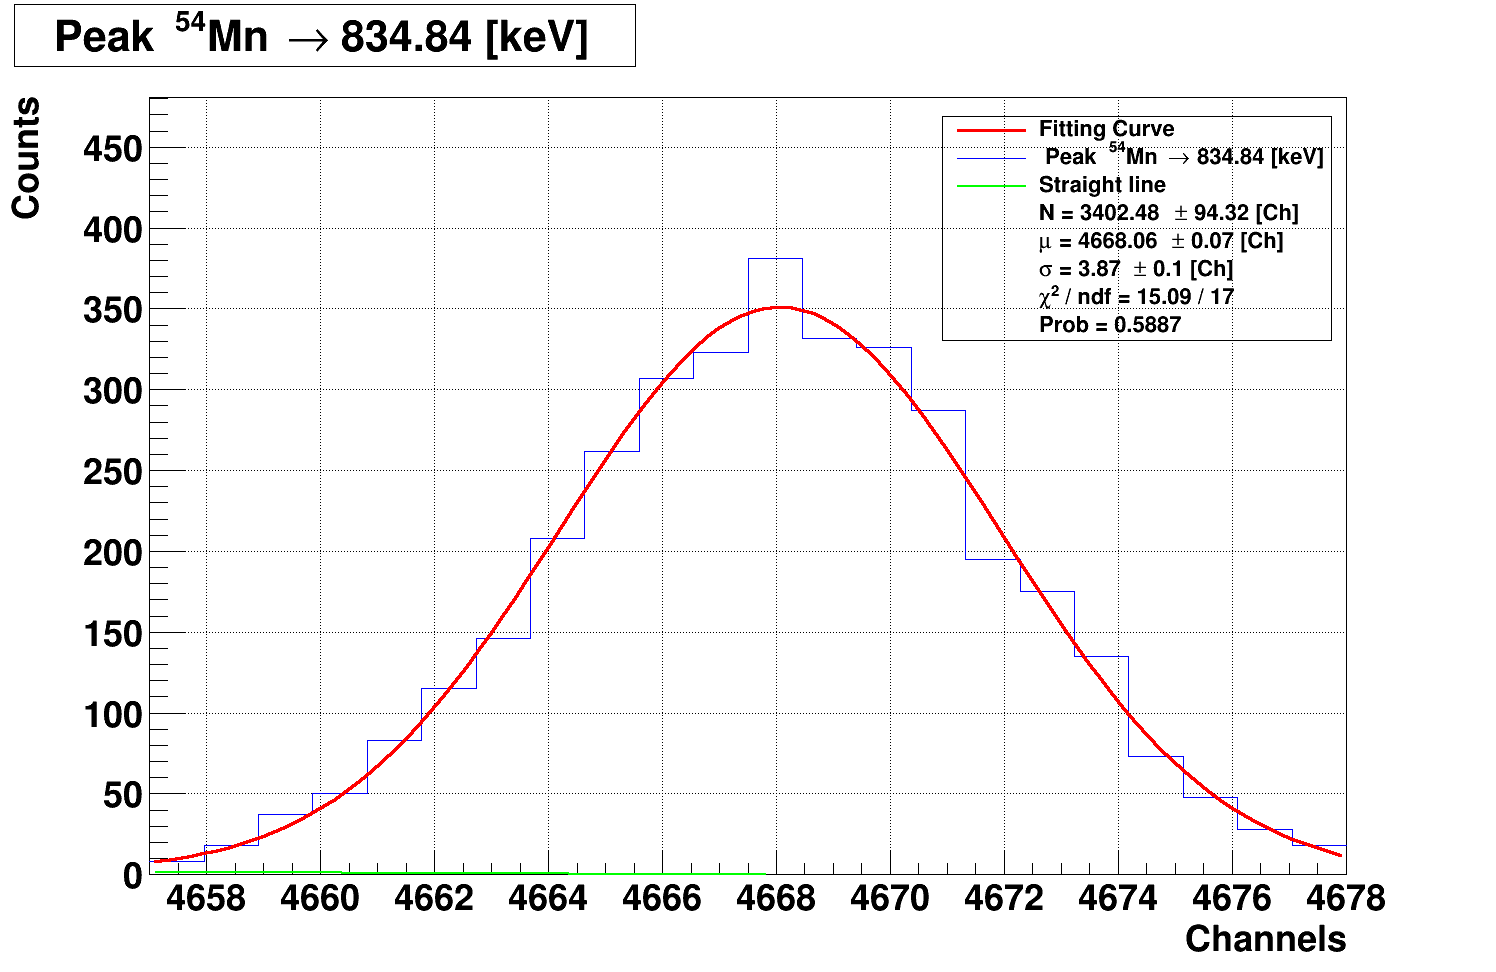

In [2]:
datos = pd.read_csv('datanalysis.csv', sep=',').to_numpy()

isotopes = {}                #Empty dictionary
name = ''

for lista in datos:
        # #carga los datos del espectro en la variable "data"
    n = 8192

    x=array('d')
    for i in range(0,8192):
        x.append(i)

    #espectro=open('../20221013_10h_th15kev_bkgd.mca','r',encoding="ISO-8859-15")
    espectro=open('./' + lista[0],'r',encoding="ISO-8859-15")
    data=array('d')
    saveFlag=False

    for line in espectro: 
        if saveFlag==True:
            if line.startswith('<<END>>'):
                saveFlag=False
            else:
                data.append(int(line))
        
        elif line.startswith('<<DATA>>'):
            saveFlag=True
        
        else:
            continue

    m = max(data)

    #############

    #define histogram
    #histograma 1, el espectro completo
    h = TH1F("h","Full",n,0,n) #parametros del histograma, de todo el espectro. Va de 0 a 8192

    #histograma 2, el pico entre los canales 2830 y 2890
    lo = lista[3]       #indices del histograma del pico
    hi = lista[4]    #el espectro va de 1 a 8192, el pico que vamos a analizar comienza esta entre "lo"y "hi"
    bins = hi-lo +1   #nùmero de bins en el Histograma 
    hz = TH1F("hz","",bins,lo,hi) #definimos hz como el histograma del pico
    hz.GetXaxis().SetTitle("Channels")
    hz.GetYaxis().SetTitle("Counts")

    for i in range(0,n): #en este for crea ambos histogramas. h, el espectro total; hz, el del pico
        h.SetBinContent(i+1,data[i]) #deposita el contenido del array en el histograma, 
        if i in range(lo,hi+1):      #bin a bin utilizando SetBinContent
            hz.SetBinContent(i-lo+1,data[i]) #define el rango entre "lo" y "hi"
                                            #y lo llenamos utilizando un for:

    #Fit Gaussian + base line to peak histogram
    #definimos la curva
    # ft = curva gausiana que queremos ajustar y una linea con pendiente 0 y ordenada al origen 5 (background) 
    fT = TF1("fT","[0]*(1/sqrt(2*3.14159*[2]^2)*exp(-0.5*((x-[1])/[2])^2))+ ([3]*x+[4])",lo,hi)
    #establecemos unos valores iniciales de cada parametro, 
    #fT.SetParameters(254.84,1368.44,4.8975,0,5) 
    fT.SetParameters( lista[5], lista[6] , lista[7], lista[8] , lista[9])
    # ajustamos la curva ft al histograma hz
    hz.Fit(fT,"R")

    norm = fT.GetParameter(0)   ############
    mean = fT.GetParameter(1)   # Parametros de la Gaussiana
    sigm = fT.GetParameter(2)   # devuelve los valores y podemos 
    slop = fT.GetParameter(3)   # almacenarlos para manipularlos despues
    cons = fT.GetParameter(4)   ############

    chi2 = fT.GetChisquare()    ###
    ndof = fT.GetNDF()          #datos de la calidad del ajuste
    Prob = fT.GetProb()         ###
    adjust = chi2/ndof          #Calidad del ajuste, si es cercano a 1, es bueno 

    errenorm = fT.GetParError(0) #Obtiene el error del parametro 0
    errmean  = fT.GetParError(1) #Obtiene el error del parametro 1
    errsig   = fT.GetParError(2) #Obtiene el error del parametro 2
    erreslop = fT.GetParError(3) #Obtiene el error del parametro 2
    errecons = fT.GetParError(4) #Obtiene el error del parametro 2



    #Creamos una TF1 que sea una linea recta y la podamos graficar en el mismo TCanvas 
    line = TF1("line", "[0]*x+[1]", lo, hi)
    line.SetParameters(slop, cons)

    print("p0 = " + str(line.GetParameter(0)))
    print("p1 = " + str(line.GetParameter(1)))


    print("errmean = " + str(errmean))
    print("norm = "+ str(norm))
    print("mean = "+ str(mean))
    print("sigm = "+ str(sigm))
    print("slop = "+ str(slop))
    print("cons = "+ str(cons))
    print("chi2/ndof = "+ str(chi2)+"/"+str(ndof) + " = " + str(adjust) )
    print("Prob = "+ str(Prob))

    #Creamos un nuevo Canvas con los datos del ajuste e imprimimos el nuevo Canvas 

    #-----Creamos strings para los nombres que vamos a usar en la clase TLegend-----
    Normname  = "N = " + str(round(norm, 2)) + " #pm " + str(round(errenorm,2)) + " [Ch]"
    meanname  = "#mu = " + str(round(mean, 2)) + " #pm " + str(round(errmean,2)) + " [Ch]"
    sigmname  = "#sigma = " + str(round(sigm, 2)) + " #pm " + str(round(errsig,2)) + " [Ch]"
    chiname   = "#chi^{2} / ndf = " + str(round(chi2, 2)) + " / " + str(ndof) 
    probname  = "Prob = " + str(round(Prob, 4))
    Framename = lista[10] + "; Channels; Counts"
    PrintName = "Peak " + lista[1] + " g3 " + str(lista[2]) + " keV.pdf" 


    #-----Se crean las leyendas que a parecen en el Canvas con los datos del ajuste y su probabilidad---
    leg = TLegend(0.63,0.88,0.89,0.65)
    leg.SetFillStyle(0)
    leg.SetBorderSize(1)
    leg.SetTextSize(0.025)
    leg.AddEntry(fT,"Fitting Curve","l")
    leg.AddEntry(hz, lista[10],"l")
    leg.AddEntry(line, "Straight line", "l")
    leg.AddEntry(0, Normname , "")
    leg.AddEntry(0, meanname , "")
    leg.AddEntry(0, sigmname , "")
    leg.AddEntry(0, chiname , "")
    leg.AddEntry(0, probname, "")


    hist_frame = TH2F("hist_frame", Framename ,1,lo,hi, 1, 0, m+100)
    hist_frame.GetYaxis().SetTitleOffset(1.3)

    c1 = TCanvas( 'c1', '', 300, 500, 1500, 1000 ) #(puntos en x,puntos en y, size (X,y))

    #c1.SetFillColor( 42 )
    c1.SetGrid()
    #---------Style-----------
    gROOT.SetStyle("Plain")
    gStyle.SetOptStat(0)
    #gPad.SetLogy(1)  #set the canvas in a log mode in y
    #---------Style-----------

    #----Set color to the lines----
    fT.SetLineColor(2)
    hz.SetLineColor(4)
    line.SetLineColor(3)

    #----Set Width to the lines-----
    line.SetLineWidth(2)

    c1.Draw()
    hist_frame.Draw()
    line.Draw("same")
    hz.Draw("same")
    fT.Draw("same")
    leg.Draw()

    c1.Print(PrintName)

    parameters = {'Norm' : str(round(norm,4))+" ± "+str(round(errenorm,4)), 
                'Mean' : str(round(mean,4))+" ± "+str(round(errmean,4)),
                'StdDev' : str(round(sigm,4))+" ± "+str(round(errsig,4)),
                'Slop' : str(round(slop,4))+" ± "+str(round(erreslop,4)),
                'Cons' : str(round(cons,4))+" ± "+str(round(errecons)),
                'Chi2 / NDF' : str(round(chi2,4))+' / '+str(ndof),
                'Prob' : str(round(Prob,4))
                }

    peak = {str(lista[2]): parameters}


    if lista[1] in isotopes:
        if lista[1] == name:
            #peak = {str(Co60[2]): parameters}
            isotopes[lista[1]][str(lista[2])]  = parameters
        else:
            isotopes[lista[1]] = peak
    else:
        isotopes[lista[1]] = peak
        name = lista[1]



    

In [3]:
#print(isotopes)

columnsFrame = ['Isotope', 'Energy [keV]', 'Data']



dicIsotopes = pd.DataFrame.from_dict({(i,j): isotopes[i][j] 
                           for i in isotopes.keys() 
                           for j in isotopes[i].keys()},
                       orient='index').to_csv('HPGe_sources.csv',sep=',')

#names_frame=pd.DataFrame(list_Names, columns=["Image ("+Tempt[6]+")"])



#Co60dict = pd.DataFrame.from_dict(isotopes['Co60'], orient='index', columns=columnsFrame)
#Na22dict = pd.DataFrame.from_dict(isotopes['Na22'], orient='index', columns=columnsFrame)

#dicIsotopes = pd.DataFrame.from_dict(isotopes)

#print(dicIsotopes)
#print(Na22dict)

In [4]:
pd.read_csv('HPGe_sources.csv', sep=',')

,Unnamed: 0,Unnamed: 1,Norm,Mean,StdDev,Slop,Cons,Chi2 / NDF,Prob
0,Co60,1173.00,24358.6199 ± 751.634,3947.9462 ± 0.0192,2.6246 ± 0.0523,-25.3182 ± 0.0387,99997.9249 ± 153,7.7821 / 7,0.3522
1,Co60,1332.00,20084.0975 ± 804.7776,4484.4061 ± 0.0219,2.648 ± 0.0666,-31.6838 ± 0.0322,142239.8708 ± 145,3.0703 / 7,0.8784
2,Na22,511.00,80086.7776 ± 898.1338,1718.4045 ± 0.0213,3.4816 ± 0.0295,-3.7878 ± 3.1672,7011.5119 ± 5448,12.2678 / 13,0.5058
3,Na22,1264.50,17896.6108 ± 478.9844,4288.7613 ± 0.0221,2.8696 ± 0.0546,-15.8103 ± 0.0225,67775.2133 ± 96,4.989 / 9,0.8353
4,Cs137,661.65,6804.067 ± 241.6837,3847.0375 ± 0.0472,3.8076 ± 0.104,-1.8696 ± 0.0105,7185.7174 ± 40,15.621 / 14,0.3371
5,Zn65,1115.53,502.6237 ± 92.1748,6239.0796 ± 0.1875,3.4806 ± 0.4406,0.1385 ± 0.0027,-858.7155 ± 17,3.696 / 12,0.9883
6,Co57,122.00,8624.5948 ± 154.8727,683.2272 ± 0.034,2.3915 ± 0.0369,0.7001 ± 1.0641,-467.863 ± 734,7.4932 / 10,0.6782
7,Co57,136.00,953.5956 ± 52.0943,763.6747 ± 0.0969,2.1696 ± 0.1018,-0.0702 ± 0.4166,63.1477 ± 318,5.2077 / 9,0.8158
8,Mn54,834.84,3402.4781 ± 94.316,4668.0626 ± 0.0675,3.8653 ± 0.0972,-0.1551 ± 0.0044,724.1005 ± 20,15.0947 / 17,0.5887


Finalmente tenemos un frame para el analisis completo de los datos, a partir de aqui, solo llenamos los archivos csv con los datos que se quieran analizar .


3.0
6471.195
p0 = -25.31815183861237
p1 = 99997.92487095068
errmean = 0.019157799205423987
norm = 24358.619878424062
mean = 3947.946175994799
sigm = 2.6246204234040853
slop = -25.31815183861237
cons = 99997.92487095068
chi2/ndof = 7.782101431530097/7 = 1.111728775932871
Prob = 0.3521997089564109
3.0
6471.195
p0 = -31.68377185347456
p1 = 142239.87076442305
errmean = 0.021908479396758836
norm = 20084.097475421717
mean = 4484.406066884811
sigm = 2.648035239191988
slop = -31.68377185347456
cons = 142239.87076442305
chi2/ndof = 3.07032279453962/7 = 0.43861754207708853
Prob = 0.8784214486480311
3.0
7218.007
p0 = 0.7025078190777582
p1 = 1300.503235157435
errmean = 0.030025550324638068
norm = 49222.22697676468
mean = 1718.3662585518941
sigm = 2.7277164120250625
slop = 0.7025078190777582
cons = 1300.503235157435
chi2/ndof = 2.4679418523469097/2 = 1.2339709261734548
Prob = 0.29113420685847197
3.0
7218.007
p0 = -15.810336707887073
p1 = 67775.2132750869
errmean = 0.022094899074299474
norm = 17896.

,Unnamed: 0,Unnamed: 1,Norm,Mean,StdDev,Slop,Cons,Chi2 / NDF,Prob,Gain,Exposure time
0,Co60,1173.00,24358.6199 ± 751.634,3947.9462 ± 0.0192,2.6246 ± 0.0523,-25.3182 ± 0.0387,99997.9249 ± 153,7.7821 / 7,0.3522,3.000,6471.195
1,Co60,1332.00,20084.0975 ± 804.7776,4484.4061 ± 0.0219,2.648 ± 0.0666,-31.6838 ± 0.0322,142239.8708 ± 145,3.0703 / 7,0.8784,3.000,6471.195
2,Na22,511.00,49222.227 ± 3954.4003,1718.3663 ± 0.03,2.7277 ± 0.0946,0.7025 ± 0.2541,1300.5032 ± 436,2.4679 / 2,0.2911,3.000,7218.007
3,Na22,1274.57,17896.6108 ± 478.9844,4288.7613 ± 0.0221,2.8696 ± 0.0546,-15.8103 ± 0.0225,67775.2133 ± 96,4.989 / 9,0.8353,3.000,7218.007
4,Cs137,661.65,6804.067 ± 241.6837,3847.0375 ± 0.0472,3.8076 ± 0.104,-1.8696 ± 0.0105,7185.7174 ± 40,15.621 / 14,0.3371,5.200,7217.991
5,Zn65,1115.53,502.6237 ± 92.1748,6239.0796 ± 0.1875,3.4806 ± 0.4406,0.1385 ± 0.0027,-858.7155 ± 17,3.696 / 12,0.9883,5.000,7218.003
6,Co57,122.00,8624.5948 ± 154.8727,683.2272 ± 0.034,2.3915 ± 0.0369,0.7001 ± 1.0641,-467.863 ± 734,7.4932 / 10,0.6782,5.000,7218.003
7,Co57,136.00,1070.922 ± 34.7383,763.7287 ± 0.0778,2.4149 ± 0.0704,-0.0738 ± 0.0885,58.669 ± 68,14.8651 / 14,0.3874,5.000,7218.003
8,Mn54,834.84,3402.4781 ± 94.316,4668.0626 ± 0.0675,3.8653 ± 0.0972,-0.1551 ± 0.0044,724.1005 ± 20,15.0947 / 17,0.5887,5.000,7218.032
9,Cd109,88.03,1568.3521 ± 161.4609,995.2606 ± 0.2135,4.3943 ± 0.3129,-0.0084 ± 0.373,13.6511 ± 369,19.8478 / 16,0.2272,9.998,5413.503


 FCN=7.7821 FROM HESSE     STATUS=NOT POSDEF     31 CALLS         288 TOTAL
                     EDM=4.62692e-08    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.43586e+04   7.51634e+02   4.45447e-02   1.06604e-06
   2  p1           3.94795e+03   1.91578e-02   9.41264e-04  -8.87739e-03
   3  p2           2.62462e+00   5.22932e-02   5.03524e-06  -1.25127e-02
   4  p3          -2.53182e+01   3.87312e-02   6.03632e-06   1.56468e-02
   5  p4           9.99979e+04   1.52681e+02   2.38414e-02   3.96013e-06
 FCN=3.07032 FROM HESSE     STATUS=NOT POSDEF     31 CALLS         293 TOTAL
                     EDM=1.68559e-07    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.00841e+04   8

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file Peak Co60 g3 1173.0 keV.pdf has been created
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hz (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file Peak Co60 g3 1332.0 keV.pdf has been created
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hz (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file Peak Na22 g3 511.0 keV.pdf has been created
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hz (Potential memory leak).
Wa

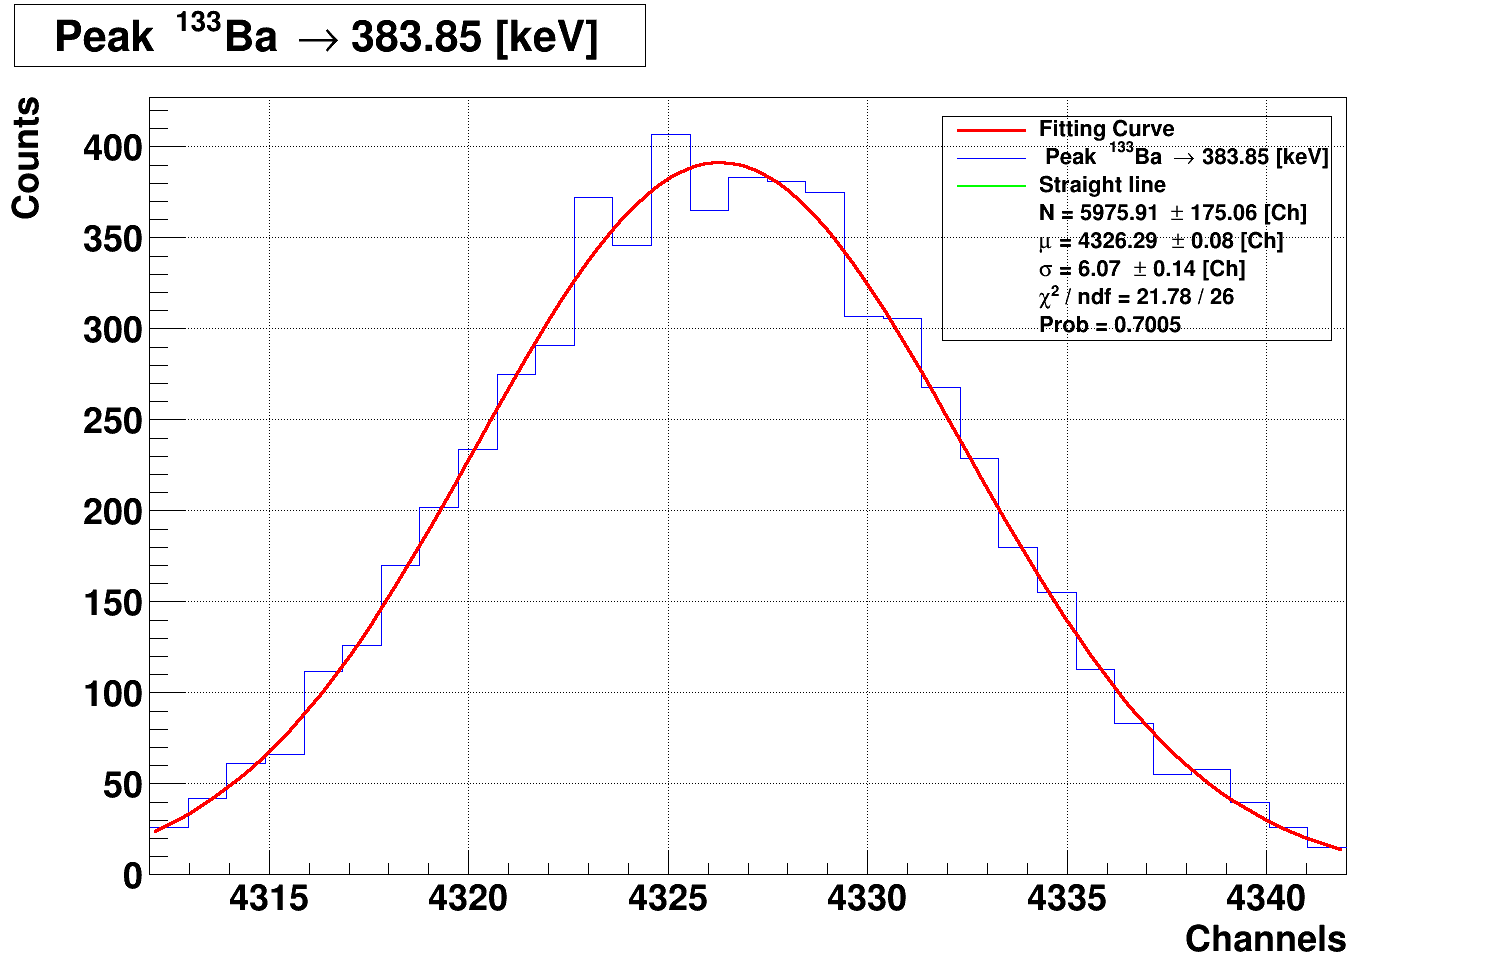

In [2]:

#--En la primer linea usando Pandas leemos un csv que contiene los datos que queremos analizar de cada 
#--isotopo, como los canales, la energia, parametros iniciales y nombre de impresion en el TCanvas, se
#--guarda en un array y se realiza el analisis de todos los elementos.

 
datos = pd.read_csv('datanalysis.csv', sep=',').to_numpy()

isotopes = {}                #Empty dictionary
name = ''

for lista in datos:
        # #carga los datos del espectro en la variable "data"
    n = 8192

    x=array('d')
    for i in range(0,8192):
        x.append(i)

    #espectro=open('../20221013_10h_th15kev_bkgd.mca','r',encoding="ISO-8859-15")
    espectro=open('./' + lista[0],'r',encoding="ISO-8859-15")
    data=array('d')
    saveFlag=False


    for line in espectro: 
        if saveFlag==True:
            if line.startswith('<<END>>'):
                saveFlag=False
            else:
                data.append(int(line))

        elif line.startswith('<<DATA>>'):
            saveFlag=True

        else:
            if line.startswith('GAIN='):
                gain=float(line.split(';', 1)[0].split('=')[1])
                print(gain)
            elif line.startswith('Real Time:'):
                time = float(line.split(' ', 2)[2])
                print(time)
            else:
                continue
            

    

    #############

    #define histogram
    #histograma 1, el espectro completo
    h = TH1F("h","Full",n,0,n) #parametros del histograma, de todo el espectro. Va de 0 a 8192

    #histograma 2, el pico entre los canales 2830 y 2890
    lo = lista[3]       #indices del histograma del pico
    hi = lista[4]    #el espectro va de 1 a 8192, el pico que vamos a analizar comienza esta entre "lo"y "hi"
    bins = hi-lo +1   #nùmero de bins en el Histograma 
    hz = TH1F("hz","",bins,lo,hi) #definimos hz como el histograma del pico
    hz.GetXaxis().SetTitle("Channels")
    hz.GetYaxis().SetTitle("Counts")
    m  = hz.GetMaximum() * 1.05

    for i in range(0,n): #en este for crea ambos histogramas. h, el espectro total; hz, el del pico
        h.SetBinContent(i+1,data[i]) #deposita el contenido del array en el histograma, 
        if i in range(lo,hi+1):      #bin a bin utilizando SetBinContent
            hz.SetBinContent(i-lo+1,data[i]) #define el rango entre "lo" y "hi"
                                            #y lo llenamos utilizando un for:

    #Fit Gaussian + base line to peak histogram
    #definimos la curva
    # ft = curva gausiana que queremos ajustar y una linea con pendiente 0 y ordenada al origen 5 (background) 
    fT = TF1("fT","[0]*(1/sqrt(2*3.14159*[2]^2)*exp(-0.5*((x-[1])/[2])^2))+ ([3]*x+[4])",lo,hi)
    #establecemos unos valores iniciales de cada parametro, 
    #fT.SetParameters(254.84,1368.44,4.8975,0,5) 
    fT.SetParameters( lista[5], lista[6] , lista[7], lista[8] , lista[9])
    # ajustamos la curva ft al histograma hz
    hz.Fit(fT,"R")

    norm = fT.GetParameter(0)   ############
    mean = fT.GetParameter(1)   # Parametros de la Gaussiana
    sigm = fT.GetParameter(2)   # devuelve los valores y podemos 
    slop = fT.GetParameter(3)   # almacenarlos para manipularlos despues
    cons = fT.GetParameter(4)   ############

    chi2 = fT.GetChisquare()    ###
    ndof = fT.GetNDF()          #datos de la calidad del ajuste
    Prob = fT.GetProb()         ###
    adjust = chi2/ndof          #Calidad del ajuste, si es cercano a 1, es bueno 

    errenorm = fT.GetParError(0) #Obtiene el error del parametro 0
    errmean  = fT.GetParError(1) #Obtiene el error del parametro 1
    errsig   = fT.GetParError(2) #Obtiene el error del parametro 2
    erreslop = fT.GetParError(3) #Obtiene el error del parametro 2
    errecons = fT.GetParError(4) #Obtiene el error del parametro 2

    #------Agregamos FWHM (Full Width at Half Maximum) para cada fit hecho, de modo que se muestre en el csv de salida----
    FWHM_1 = 2 * math.sqrt(2*math.log(2))
    fwhm = FWHM_1 * sigm
    errfwhm = FWHM_1 * errsig
    #--------------------------------------------------------------------------------------------------------------------#

    #----Calculamos el delta sigma como se muestra en la tesis de Ivan Ortega Hernandez-------
    erresig_2 = sigm / (math.sqrt(2*(norm - 1)))
    errefwhm_2 = FWHM_1 * erresig_2



    #Creamos una TF1 que sea una linea recta y la podamos graficar en el mismo TCanvas 
    line = TF1("line", "[0]*x+[1]", lo, hi)
    line.SetParameters(slop, cons)

    print("p0 = " + str(line.GetParameter(0)))
    print("p1 = " + str(line.GetParameter(1)))


    print("errmean = " + str(errmean))
    print("norm = "+ str(norm))
    print("mean = "+ str(mean))
    print("sigm = "+ str(sigm))
    print("slop = "+ str(slop))
    print("cons = "+ str(cons))
    print("chi2/ndof = "+ str(chi2)+"/"+str(ndof) + " = " + str(adjust) )
    print("Prob = "+ str(Prob))

    #Creamos un nuevo Canvas con los datos del ajuste e imprimimos el nuevo Canvas 

    #-----Creamos strings para los nombres que vamos a usar en la clase TLegend-----
    Normname  = "N = " + str(round(norm, 2)) + " #pm " + str(round(errenorm,2)) + " [Ch]"
    meanname  = "#mu = " + str(round(mean, 2)) + " #pm " + str(round(errmean,2)) + " [Ch]"
    sigmname  = "#sigma = " + str(round(sigm, 2)) + " #pm " + str(round(errsig,2)) + " [Ch]"
    chiname   = "#chi^{2} / ndf = " + str(round(chi2, 2)) + " / " + str(ndof) 
    probname  = "Prob = " + str(round(Prob, 4))
    Framename = lista[10] + "; Channels; Counts"
    PrintName = "Peak " + lista[1] + " g3 " + str(lista[2]) + " keV.pdf" 


    #-----Se crean las leyendas que a parecen en el Canvas con los datos del ajuste y su probabilidad---
    leg = TLegend(0.63,0.88,0.89,0.65)
    leg.SetFillStyle(0)
    leg.SetBorderSize(1)
    leg.SetTextSize(0.025)
    leg.AddEntry(fT,"Fitting Curve","l")
    leg.AddEntry(hz, lista[10],"l")
    leg.AddEntry(line, "Straight line", "l")
    leg.AddEntry(0, Normname , "")
    leg.AddEntry(0, meanname , "")
    leg.AddEntry(0, sigmname , "")
    leg.AddEntry(0, chiname , "")
    leg.AddEntry(0, probname, "")


    # hist_frame = TH2F("hist_frame", Framename ,1,lo,hi, 1, 0, m)
    # hist_frame.GetYaxis().SetTitleOffset(1.3)
    hz.SetTitle(Framename)
    hz.GetYaxis().SetTitleOffset(1.3)
    # hz.GetYaxis().SetRangeUser(0,m)

    c1 = TCanvas( 'c1', '', 300, 500, 1500, 1000 ) #(puntos en x,puntos en y, size (X,y))

    #c1.SetFillColor( 42 )
    c1.SetGrid()
    #---------Style-----------
    gROOT.SetStyle("Plain")
    gStyle.SetOptStat(0)
    #gPad.SetLogy(1)  #set the canvas in a log mode in y
    #---------Style-----------

    #----Set color to the lines----
    fT.SetLineColor(2)
    hz.SetLineColor(4)
    line.SetLineColor(3)

    #----Set Width to the lines-----
    line.SetLineWidth(2)

    #c1.Draw()
    # c1.Divide(1,1)
    # c1.cd(1)
    # c1.cd(1).SetLogy()
    # hist_frame.Draw()
    hz.SetMinimum(0)
    hz.Draw()
    line.Draw("same")
    fT.Draw("same")
    leg.Draw()
    c1.Update()
    c1.Draw()

    c1.Print(PrintName)

    parameters = {'Norm' : str(round(norm,4))+" ± "+str(round(errenorm,4)), 
                'Mean' : str(round(mean,4))+" ± "+str(round(errmean,4)),
                'StdDev' : str(round(sigm,4))+" ± "+str(round(errsig,4)),
                'Slop' : str(round(slop,4))+" ± "+str(round(erreslop,4)),
                'Cons' : str(round(cons,4))+" ± "+str(round(errecons)),
                'Chi2 / NDF' : str(round(chi2,4))+' / '+str(ndof),
                'Prob' : str(round(Prob,4)),
                'Gain' : gain,
                'Exposure time' : time
                # 'errStdDev' : round(errsig,4),
                # 'errStdDev_V2' : round(erresig_2, 4),
                # 'FWHM(sig)' : round(fwhm,4) ,
                # 'err_FWHM' : round(errfwhm, 4),
                # 'err_FWHM_V2' : round(errefwhm_2, 4)
                }

    peak = {str(lista[2]): parameters}


    if lista[1] in isotopes:
        if lista[1] == name:
            #peak = {str(Co60[2]): parameters}
            isotopes[lista[1]][str(lista[2])]  = parameters
        else:
            isotopes[lista[1]] = peak
    else:
        isotopes[lista[1]] = peak
        name = lista[1]


#-----Creamos el Frame del diccionario para mostrarlo de un amanera optima y despues leerlo si es necesario---
dicIsotopes = pd.DataFrame.from_dict({(i,j): isotopes[i][j] 
                           for i in isotopes.keys() 
                           for j in isotopes[i].keys()},
                       orient='index').to_csv('HPGe_sources.csv',sep=',')



#-----Confirmamos que se crea el archivo y pedimos que nos los muestre en terminal---
#-----Podemos modificar el archivo csv y nombrar las columnas, eso no afecta el programa---

pd.read_csv('HPGe_sources.csv', sep=',')

Obtendremos la Linealidad de los datos una vez que ya analizamos todos los datos presentes en los archivos csv creados anteriormente.

Ya esta terminado

,Unnamed: 0,Unnamed: 1,Norm,Sigma,Sigma_error,Mean,Mean_error,Gain
0,^{60}Co,1173.00,24358.6199,2.624600,0.052563,3947.946200,7.895916,3.000
1,^{60}Co,1332.00,20084.0975,2.648000,0.066810,4484.406100,8.968839,3.000
2,^{22}Na,511.00,49222.2270,2.727700,0.094757,1718.366300,3.436864,3.000
3,^{22}Na,1274.57,17896.6108,2.869600,0.054901,4288.761300,8.577551,3.000
4,^{137}Cs,661.65,6804.0670,2.196692,0.060161,2219.444712,4.438973,5.200
5,^{65}Zn,1115.53,502.6237,2.088360,0.264393,3743.447760,7.487741,5.000
6,^{57}Co,122.00,8624.5948,1.434900,0.022325,409.936320,0.820126,5.000
7,^{57}Co,136.00,1070.9220,1.448940,0.042339,458.237220,0.917662,5.000
8,^{54}Mn,834.84,3402.4781,2.319180,0.058504,2800.837560,5.601822,5.000
9,^{109}Cd,88.03,1568.3521,1.318554,0.093926,298.637908,0.600702,9.998


 FCN=34.9966 FROM MIGRAD    STATUS=CONVERGED      34 CALLS          35 TOTAL
                     EDM=1.61727e-19    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.29771e+00   3.31725e-01   7.75492e-04  -2.74874e-10
   2  p1           3.36240e+00   2.33020e-03   4.94689e-06   2.15451e-07
 FCN=14 FROM MIGRAD    STATUS=CONVERGED      24 CALLS          25 TOTAL
                     EDM=5.2729e-19    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.29771e+00   5.24479e-01   0.00000e+00  -1.21100e-09
   2  p1           3.36240e+00   3.68419e-03  -0.00000e+00   2.55078e-07
 FCN=14 FROM MIGRAD    STATUS=CONVERGED      24 CALLS          25 TOTAL
                     EDM=2.06034e-16    

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file Linearity_correction.pdf has been created
Info in <TCanvas::Print>: pdf file Calibration_Ch_vs_keV.pdf has been created


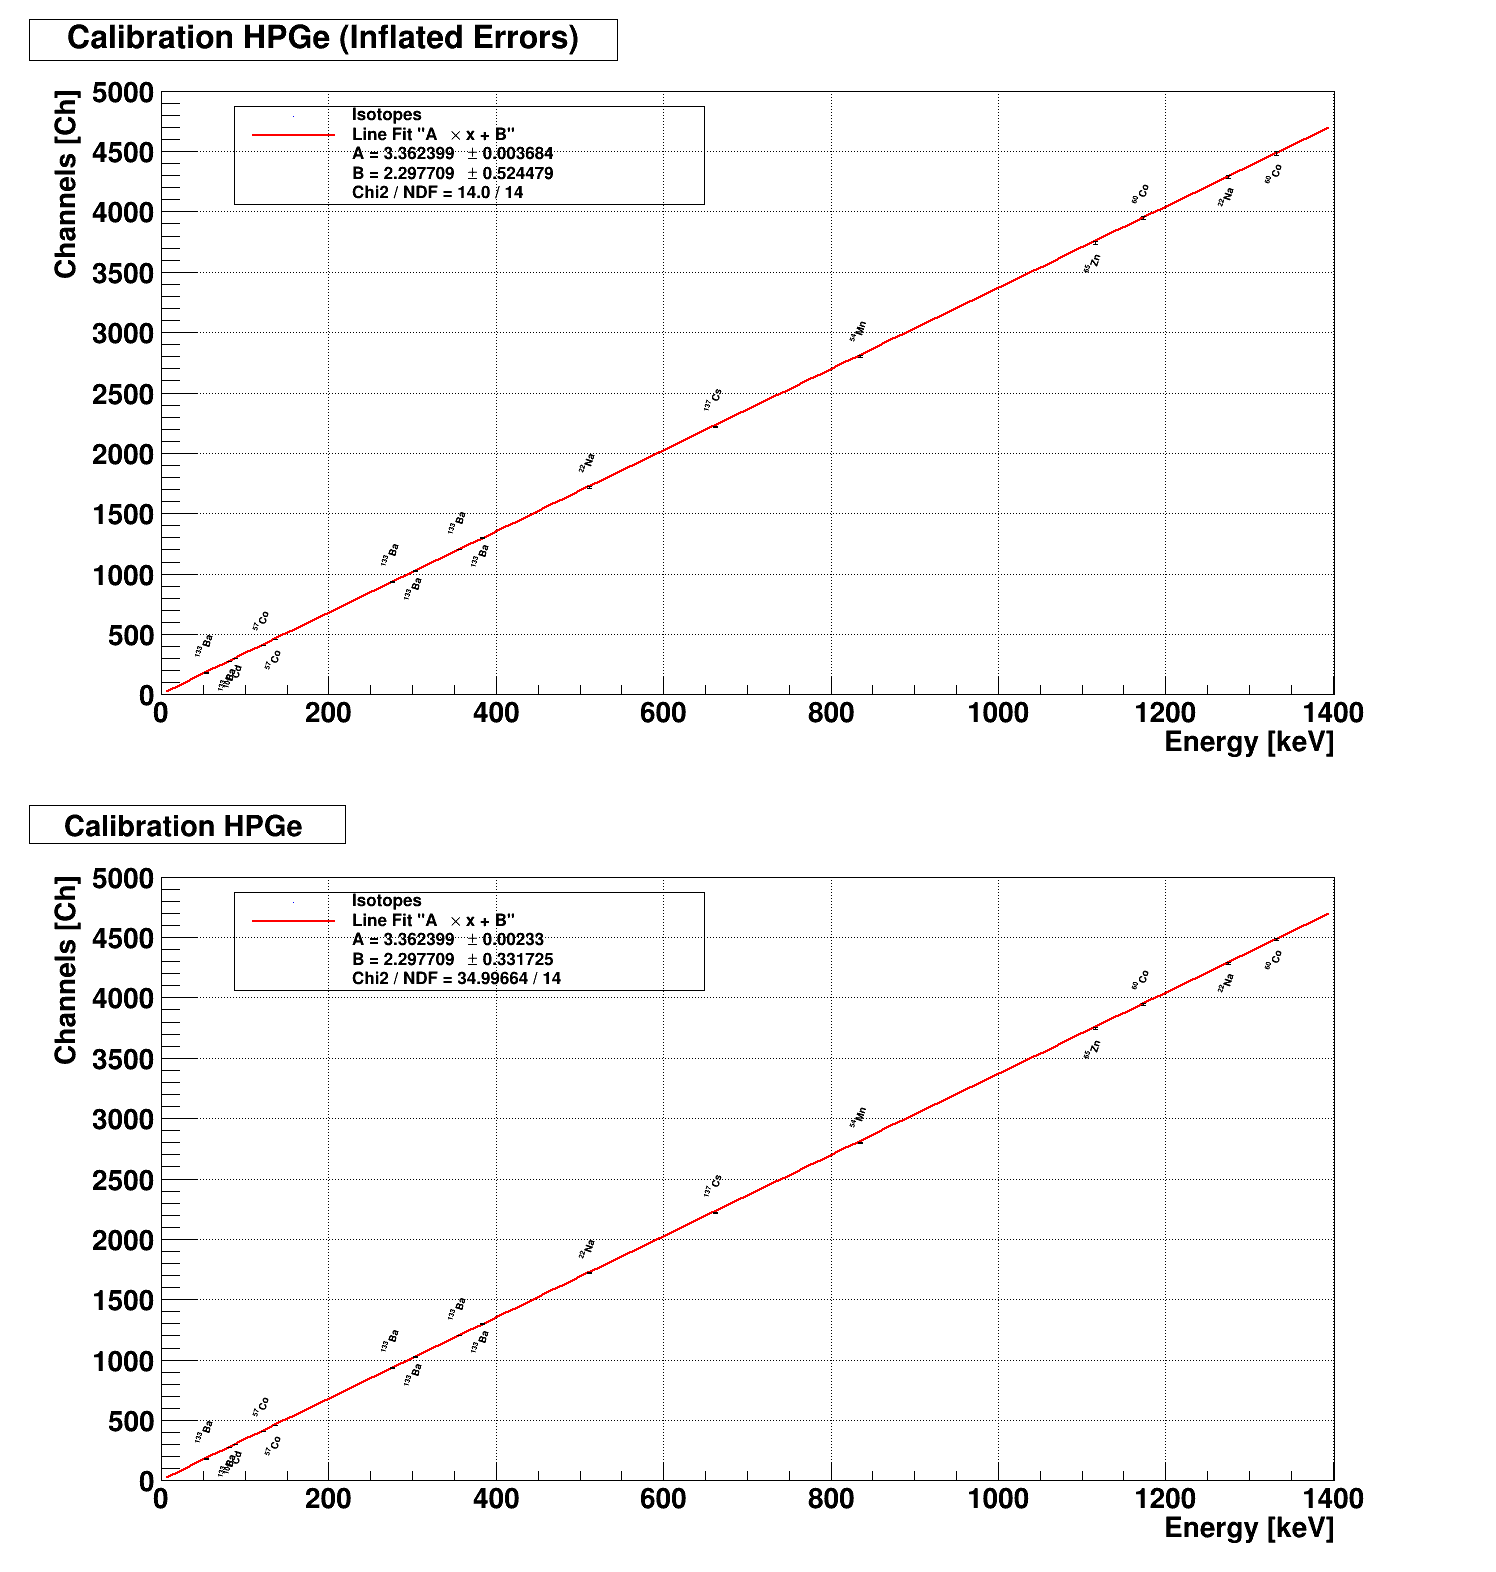

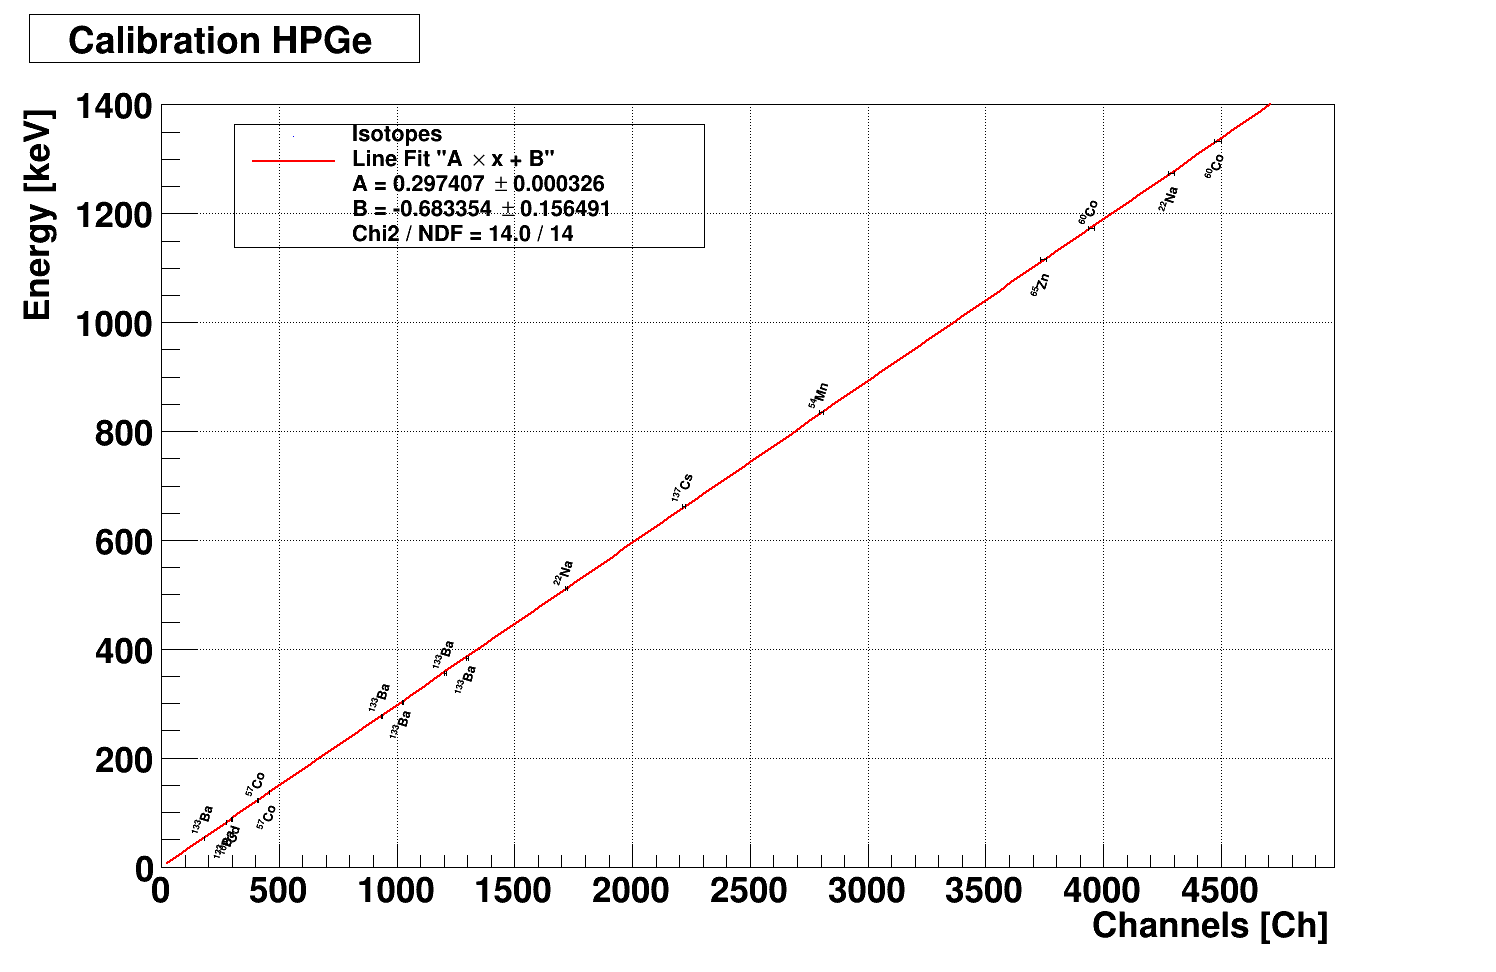

In [3]:
# En el siguiente Script se analizan los datos obtenidos del analisi hecho con rROOT y almacenado en el
# archivo 'HPGe_sources.csv', de modo que se obtiene la grafica de la calibracion del HPGe


c1 = TCanvas( 'c1', '', 300, 600, 1500, 1600 ) #(puntos en x,puntos en y, size (X,y))
c2 = TCanvas( 'c2', 'c2 ', 300, 500, 1500, 1000 ) #(puntos en x,puntos en y, size (X,y))

#c1.SetFillColor( 42 )
c1.SetGrid()
#---------Style-----------
gROOT.SetStyle("Plain")
gStyle.SetOptStat(0)
#gPad.SetLogy(1)  #set the canvas in a log mode in y
#---------Style-----------
latex = TLatex()


pd.read_csv('HPGe_sources.csv', sep=',')
pd.read_csv('datanalysis.csv', sep=',')

Linearity_data = {}
key_name = ''

energy = array('d')
Normarray = array('d')
meanarray = array('d')
meanarrayerror = array('d')
sigmarray = array('d')
sigmarrayerror = array('d')
gainarray = array('d')
chi2array = array('d')
ndfarray = array('d')
names = []

obtnames = pd.read_csv('datanalysis.csv', sep=',').to_numpy()

#----Obtiene los nombres de todos los isotopos en un formato  LaTex que se puede usar en los Canvas de ROOT--
for lista in obtnames:
    names.append(lista[10].split(' ',3)[2])
#-----------------------------------------------------------------------------------------------------------#


#----Obtiene el nombre de solo un isotopo, el que se desea analizar------------
# for lista in obtnames:
#     if 'Ba' in lista[10]:
#         names.append(lista[10].split(' ',3)[2])
#     else:
#         continue
#-----------------------------------------------------------------------------#

dataanlysis = pd.read_csv('HPGe_sources.csv', sep=',').to_numpy()

#---Leemos del csv creado para todos los elememtos analizados en el experimento---------
for lista in dataanlysis:
    energy.append(lista[1])
    Normarray.append(float(lista[2].split(' ')[0]))
    meanarray.append(float(lista[3].split(' ')[0]))
    meanarrayerror.append(float(lista[3].split(' ')[2]))
    sigmarray.append(float(lista[4].split(' ')[0]))
    sigmarrayerror.append(float(lista[4].split(' ')[2]))
    gainarray.append(lista[9])
#-------------------------------------------------------------------------------------#

#----Aqui lo haremos para solo un isotopo, como ejemplo tomaremos solo el array del Ba133---
# for lista in dataanlysis:
#     if lista[0].startswith('Ba133'):
#         energy.append(lista[1])
#         Normarray.append(float(lista[2].split(' ')[0]))
#         meanarray.append(float(lista[3].split(' ')[0]))
#         meanarrayerror.append(float(lista[3].split(' ')[2]))
#         sigmarray.append(float(lista[4].split(' ')[0]))
#         sigmarrayerror.append(float(lista[4].split(' ')[2]))
#         gainarray.append(lista[9])
#         chi2array.append(float(lista[7].split(' ')[0]))
#         ndfarray.append(float(lista[7].split(' ')[2]))
#     else:
#         continue
#------------------------------------------------------------------------------------------#


factorgain = array('d')
for item in gainarray:
    factorgain.append(3./item)

mearray =  np.array(meanarray)
factgain = np.array(factorgain)
# errorcorrection = np.array(chi2array) / np.array(ndfarray)
# errorcorrection = np.sqrt( np.power(np.array(meanarrayerror), 2) + np.power(0.002, 2) * np.power(np.array(meanarray), 2))

#meancorr = array('d', mearray * factgain)
meancorr     = array('d', np.array(meanarray) * 3 / np.array(gainarray))
meanerrcorr  = array('d', np.array(meanarrayerror) * 3/np.array(gainarray))
sigmacorr    = array('d', np.array(sigmarray) * 3/np.array(gainarray))
sigmaerrcorr = array('d', np.array(sigmarrayerror) * 3/np.array(gainarray))
# meanerrcorr = array('d', np.array(meanarrayerror) * np.sqrt(53.84002 / 4))

errorcorrection = np.sqrt( np.power(np.array(meanerrcorr), 2) + np.power(0.002, 2) * np.power(np.array(meancorr), 2))
sigmaerrorcorrection  = np.sqrt( np.power(np.array(sigmaerrcorr), 2) + np.power(0.002, 2) * np.power(np.array(sigmacorr), 2))

line = TF1('line', '[0]+[1]*x', 0, 8150)
line.SetParameters(0, 3)
line.SetLineColor(2)
line.SetLineWidth(2)


# grapherror = TGraphErrors(len(energy), energy, meanarray, 0, errorcorrection)                #---En esta linea se crea una TGraph donde se escalan por el factor de ganancia los valores de mean y error mean 
grapherror = TGraphErrors(len(energy), energy, meancorr, 0, errorcorrection)                  #---En esta linea se crea una TGraph donde solo se escala el mean y se deja sin escalar el mean error
# grapherror = TGraphErrors(len(meanarray), meanarray, energy, meanarrayerror, 0)              #---En esta linea no se escala ningun valor y se grafica Canales contra energía
grapherror.SetTitle("Calibration HPGe with ^{133}Ba")
grapherror.SetTitle("Calibration HPGe")
grapherror.GetXaxis().SetTitle("Energy [keV]")
grapherror.GetYaxis().SetTitle("Channels [Ch]")

grapherror.Fit(line,'R')
chi2 = line.GetChisquare()
NDF = line.GetNDF()
adjust = chi2 / NDF

p0 = 'A = ' + str(round(line.GetParameter(1), 6)) + ' #pm ' + str(round(line.GetParError(1), 6)) 
p1 = 'B = ' + str(round(line.GetParameter(0), 6)) + ' #pm ' + str(round(line.GetParError(0), 6))
adj = 'Chi2 / NDF = ' + str(round(chi2,5)) + ' / ' + str(NDF)


# meanarrayerror_2 = array('d', math.sqrt(chi2) * np.array(meanerrcorr))
meanarrayerror_2 = array('d', math.sqrt(adjust) * np.array(errorcorrection))
grapherror_2 = TGraphErrors(len(energy), energy, meancorr, 0, meanarrayerror_2)
grapherror_2.SetTitle("Calibration HPGe (Inflated Errors)")
grapherror_2.GetXaxis().SetTitle("Energy [keV]")
grapherror_2.GetYaxis().SetTitle("Channels [Ch]")

grapherror_2.Fit(line,'R')
chi2 = line.GetChisquare()
NDF = line.GetNDF()
adjust = chi2 / NDF


p0_2 = 'A = ' + str(round(line.GetParameter(1), 6)) + ' #pm ' + str(round(line.GetParError(1), 6)) 
p1_2 = 'B = ' + str(round(line.GetParameter(0), 6)) + ' #pm ' + str(round(line.GetParError(0), 6))
adj_2 = 'Chi2 / NDF = ' + str(round(chi2,5)) + ' / ' + str(NDF)

#----calculamos datos de Fits para la resolucion del detector HPGe--------------
energyline = TF1('energyline', '[0] + [1]*x', 0 , 5000)
energyline.SetParameters(-1*(line.GetParameter(0) / line.GetParameter(1)), 1/ line.GetParameter(1))
energyline.SetLineColor(2)
energyline.SetLineWidth(2)

chan_energy = TGraphErrors(len(meancorr), meancorr, energy, meanarrayerror_2, 0)
chan_energy.SetTitle("Calibration HPGe")
chan_energy.GetXaxis().SetTitle("Channels [Ch]")
chan_energy.GetYaxis().SetTitle("Energy [keV]")
chan_energy.GetYaxis().SetTitleOffset(1.3)


chan_energy.Fit(energyline, 'R')

chi2 = energyline.GetChisquare()
NDF = energyline.GetNDF()
adjust = chi2 / NDF


p0_3 = 'A = ' + str(round(energyline.GetParameter(1), 6)) + ' #pm ' + str(round(energyline.GetParError(1), 6)) 
p1_3 = 'B = ' + str(round(energyline.GetParameter(0), 6)) + ' #pm ' + str(round(energyline.GetParError(0), 6))
adj_3 = 'Chi2 / NDF = ' + str(round(chi2,5)) + ' / ' + str(NDF)

#-------------------------------------------------------------------------------



#----Llenamos el diccionario vacio para los datos provenientes del analisis------------
for i in range(len(names)):
    data = {'Norm'       : Normarray[i],
            'Sigma'      : sigmacorr[i],
            'Sigma_error': sigmaerrorcorrection[i],
            'Mean'       : meancorr[i],
            'Mean_error' : errorcorrection[i],
            'Gain'       : gainarray[i]
            }
    
    peakdata = {str(energy[i]) : data}
    
    if names[i] in Linearity_data:
        if names[i] == key_name:
            Linearity_data[names[i]][str(energy[i])] = data
        else:
            Linearity_data[names[i]] = peakdata
    else:
        Linearity_data[names[i]] = peakdata
        key_name = names[i]
#----------------------------------------------------------------------------------


#-----Se declaran las leyendas que van a aparecer en las graficas, cada una correspondiente con los datos obtenidos----------
leg = TLegend(0.15,0.88,0.47,0.75)
leg.SetFillStyle(0)
leg.SetBorderSize(1)
leg.SetTextSize(0.025)
leg.AddEntry(grapherror, 'Isotopes', 'p')
leg.AddEntry(line, 'Line Fit "A #times x + B" ', 'l')
leg.AddEntry(0, p0, '')
leg.AddEntry(0, p1, '')
leg.AddEntry(0, adj, '')

leg2 = TLegend(0.15,0.88,0.47,0.75)
leg2.SetFillStyle(0)
leg2.SetBorderSize(1)
leg2.SetTextSize(0.025)
leg2.AddEntry(grapherror_2, 'Isotopes', 'p')
leg2.AddEntry(line, 'Line Fit "A #times x + B" ', 'l')
leg2.AddEntry(0, p0_2, '')
leg2.AddEntry(0, p1_2, '')
leg2.AddEntry(0, adj_2, '')

leg3 = TLegend(0.15,0.88,0.47,0.75)
leg3.SetFillStyle(0)
leg3.SetBorderSize(1)
leg3.SetTextSize(0.025)
leg3.AddEntry(chan_energy, 'Isotopes', 'p')
leg3.AddEntry(energyline, 'Line Fit "A #times x + B" ', 'l')
leg3.AddEntry(0, p0_3, '')
leg3.AddEntry(0, p1_3, '')
leg3.AddEntry(0, adj_3, '')
#----------------------------------------------------------------------------------------------------------------------------


c1.Divide(1,2)
# c1.Draw()

c1.cd(1)
c1.cd(1).SetGrid()
line.Draw()
grapherror_2.Draw("AP")
# grapherror_2.SetMarkerStyle(20)
grapherror_2.SetMarkerSize(0.5)
grapherror_2.SetMarkerColor(4)
grapherror_2.GetYaxis().SetRangeUser(0,5000)
grapherror_2.GetXaxis().SetRangeUser(0,1400)
# line.Draw("same")
leg2.Draw()

for i in range(len(names)):
    latex.SetTextSize(0.015)
    latex.SetTextColor(1)
    latex.SetTextAngle(73)
    if math.fmod(i,2) == 0:
        latex.DrawLatex(energy[i], meancorr[i]+100, names[i])
    else:
        latex.DrawLatex(energy[i], meancorr[i]-270, names[i])

c1.Update()


c1.cd(2)
c1.cd(2).SetGrid()
line.Draw()
grapherror.Draw("AP")
# grapherror.SetMarkerStyle(20)
grapherror.SetMarkerSize(0.5)
grapherror.SetMarkerColor(4)
grapherror.GetYaxis().SetRangeUser(0,5000)
grapherror.GetXaxis().SetRangeUser(0,1400)
# line.Draw("same")
leg.Draw()

for i in range(len(names)):
    latex.SetTextSize(0.015)
    latex.SetTextColor(1)
    latex.SetTextAngle(73)
    if math.fmod(i,2) == 0:
        latex.DrawLatex(energy[i], meancorr[i]+100, names[i])
    else:
        latex.DrawLatex(energy[i], meancorr[i]-270, names[i])

c1.Update()
c1.Draw()

c1.Print('Linearity_correction.pdf')

c2.Divide(1,1)
c2.cd(1)
c2.cd(1).SetGrid()
energyline.Draw()
chan_energy.Draw("AP")
# chan_energy.SetMarkerStyle(20)
chan_energy.SetMarkerSize(1)
chan_energy.SetMarkerColor(4)
chan_energy.GetYaxis().SetRangeUser(0,1400)
chan_energy.GetXaxis().SetRangeUser(0,5000)
# energyline.Draw("same")
leg3.Draw()

for i in range(len(names)):
    latex.SetTextSize(0.015)
    latex.SetTextColor(1)
    latex.SetTextAngle(73)
    if math.fmod(i,2) == 0:
        latex.DrawLatex(meancorr[i], energy[i], names[i])
    else:
        latex.DrawLatex(meancorr[i], energy[i]-75, names[i])

c2.Update()
c2.Draw()
c2.Print('Calibration_Ch_vs_keV.pdf')


#---Se usan los datos inversos a los obtenidos para calcular los errores realacionados alos parametros ajustados en el fit-----
#---de modo que para calcular la eficiencia tomamos los datos de un fit de Canal [Ch] contra energia [keV].--------------------
linearity = {'slop'      : energyline.GetParameter(1),
            'slop_error' : energyline.GetParError(1),
            'const'      : energyline.GetParameter(0),
            'const_error': energyline.GetParError(0)
            }
#------------------------------------------------------------------------------------------------------------------------------


#-----Creamos el Frame del diccionario para mostrarlo de una manera optima y despues leerlo si es necesario---
dicLinearity = pd.DataFrame.from_dict({(i,j): Linearity_data[i][j] 
                           for i in Linearity_data.keys() 
                           for j in Linearity_data[i].keys()},
                       orient='index').to_csv('Linearity_data.csv',sep=',')



pd.DataFrame.from_dict(linearity, orient='index', columns=['Line parameters']).to_csv('Line_parameter.csv', sep=',')

pd.read_csv('Linearity_data.csv', sep=',')



Se calculará el FWHM (Full Width at Half Maximun) con los datos obtenidos del analisis realizado con ROOT, los adtos de este analisis se encuentran en el archivo 'HPGe_sources.csv


array('d', [1173.0, 1332.0, 511.0, 1274.57, 661.65, 1115.53, 122.0, 136.0, 834.84, 88.03, 53.16, 80.9, 276.39, 302.85, 356.0, 383.85])
array('d', [1173.4622755400935, 1333.0090411411027, 510.3702873150254, 1274.822967873266, 659.3943613855249, 1112.6430704653956, 121.23445195362564, 135.5994629649198, 832.3044866634742, 88.1335590110287, 53.15928609663417, 81.08236609038968, 277.3775124851803, 303.95001094671227, 357.3794403868626, 385.355603861737])
array('d', [1.6649442606795954, 1.9840388012400192, 0.33879228283407603, 1.8676671700150043, 0.6368263303873346, 1.5435502698741725, -0.4394428602739238, -0.41043497692025876, 0.9826652822213923, -0.5047012559249666, -0.5746117026770294, -0.5198083619302362, -0.12719183463825645, -0.07406553252412118, 0.03277681920559272, 0.08875839182678535])


,Unnamed: 0,Unnamed: 1,energy_calc,percent_err,Sigma,err_sigma,Mean,err_mean,delta_FWHM,delta_Res
0,^{60}Co,1173.00,1173.462276,0.039410,2.624600,0.052563,3947.946200,7.895916,0.000105,0.000032
1,^{60}Co,1332.00,1333.009041,0.075754,2.648000,0.066810,4484.406100,8.968839,0.000118,0.000035
2,^{22}Na,511.00,510.370287,0.123231,2.727700,0.094757,1718.366300,3.436864,0.000437,0.000130
3,^{22}Na,1274.57,1274.822968,0.019847,2.869600,0.054901,4288.761300,8.577551,0.000101,0.000030
4,^{137}Cs,661.65,659.394361,0.340911,2.196692,0.060161,2219.444712,4.438973,0.000215,0.000064
5,^{65}Zn,1115.53,1112.643070,0.258794,2.088360,0.264393,3743.447760,7.487741,0.000560,0.000166
6,^{57}Co,122.00,121.234452,0.627498,1.434900,0.022325,409.936320,0.820126,0.000434,0.000129
7,^{57}Co,136.00,135.599463,0.294513,1.448940,0.042339,458.237220,0.917662,0.000735,0.000218
8,^{54}Mn,834.84,832.304487,0.303712,2.319180,0.058504,2800.837560,5.601822,0.000166,0.000049
9,^{109}Cd,88.03,88.133559,0.117641,1.318554,0.093926,298.637908,0.600702,0.002510,0.000741


 FCN=161.214 FROM MIGRAD    STATUS=CONVERGED     107 CALLS         108 TOTAL
                     EDM=1.18154e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.44937e-02   8.25658e-04   1.33624e-06  -2.85098e-01
   2  p1          -4.05094e+01   7.57134e-01   2.63974e-03   1.03880e-03
   3  p2          -6.65374e-04   3.64171e-05   7.11786e-08  -3.07027e+01


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


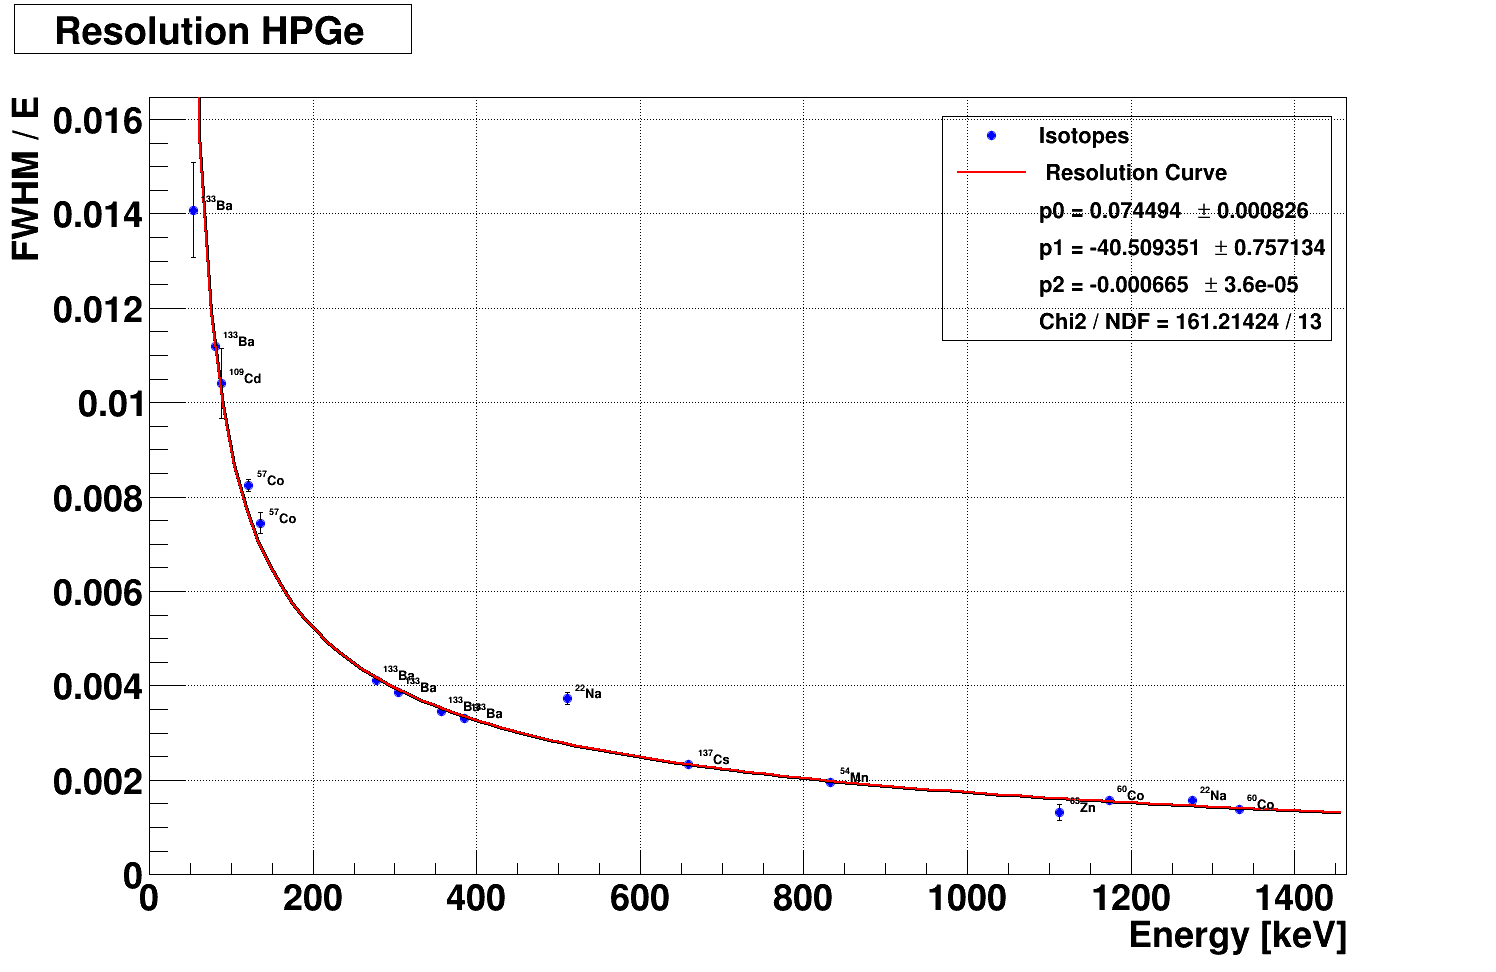

In [11]:

c1 = TCanvas( 'c1', '', 300, 500, 1500, 1000 ) #(puntos en x,puntos en y, size (X,y))
#c1 = TCanvas()

#c1.SetFillColor( 42 )
c1.SetGrid()
#---------Style-----------
gROOT.SetStyle("Plain")
gStyle.SetOptStat(0)
#gPad.SetLogy(1)  #set the canvas in a log mode in y
#---------Style-----------
latex = TLatex()


pd.read_csv('HPGe_sources.csv', sep=',')
pd.read_csv('datanalysis.csv', sep=',')
pd.read_csv('Line_parameter.csv', sep=',')

Resolution_data = {}                        #------Diccionario vacio
key_name = ''

energy = array('d')
Normarray = array('d')
meanarray = array('d')
meanarrayerror = array('d')
sigmarray = array('d')  
sigmarrayerror = array('d')
gainarray = array('d')
names = []


line_parameters = pd.read_csv('Line_parameter.csv', sep=',').to_numpy()
slop        = line_parameters[0][1]
slop_error  = line_parameters[1][1]
const       = line_parameters[2][1]
const_error = line_parameters[3][1]

dataanlysis = pd.read_csv('Linearity_data.csv', sep=',').to_numpy()
for lista in dataanlysis:
    names.append(lista[0])
    energy.append(lista[1])
    Normarray.append(lista[2])
    sigmarray.append(lista[3])
    sigmarrayerror.append(lista[4])
    meanarray.append(lista[5])
    meanarrayerror.append(lista[6])
    gainarray.append(lista[7]) 

# obtnames = pd.read_csv('datanalysis.csv', sep=',').to_numpy()
# for lista in obtnames:
#     names.append(lista[10].split(' ',3)[2])

# dataanlysis = pd.read_csv('HPGe_sources.csv', sep=',').to_numpy()
# for lista in dataanlysis:
#     energy.append(lista[1])
#     Normarray.append(float(lista[2].split(' ')[0]))
#     meanarray.append(float(lista[3].split(' ')[0]))
#     meanarrayerror.append(float(lista[3].split(' ')[2]))
#     sigmarray.append(float(lista[4].split(' ')[0]))
#     sigmarrayerror.append(float(lista[4].split(' ')[2]))
#     gainarray.append(lista[9])

# meancorr = array('d', 3./np.array(gainarray) * np.array(meanarray))


energy_2 = array('d', slop * np.array(meanarray) + const)
sigm_calib = array('d', slop * np.array(sigmarray) + const)
sigm_err_calib = array('d', slop * np.array(sigmarrayerror) + const)
mean_calib = array('d', slop * np.array(meanarray) + const)
mean_err_calib = array('d', slop * np.array(meanarrayerror) + const)
# energy_error = array('d',  np.sqrt( np.power(np.array(energy_2), 2) * (np.power(const_error/const, 2) + np.power(slop_error/slop , 2) + np.power(np.array(meanarrayerror)/np.array(meanarray),2)) ))
# energy_error = array('d', slop_error * np.array(meanarrayerror) + const_error)
energy_error = array('d', slop * np.array(meanarrayerror) + const)
perceterror = array('d', np.absolute((np.array(energy)- np.array(energy_2)) / np.array(energy)) * 100)


FWHM_1 = 2 * math.sqrt(2*math.log(2))


FWHM = array('d', FWHM_1 * np.array(sigmarray))
FWHM_err = array('d', FWHM_1 * np.array(sigmarrayerror))

# FWHM = array('d', FWHM_1 * np.array(sigm_calib))
# FWHM_err = array('d', FWHM_1 * np.array(sigm_err_calib))

# for item in sigmarray:
#     FWHM.append(FWHM_1*item)

# Energy = np.array(energy)
# fwhm = np.array(FWHM)

# Res =  array('d', np.array(FWHM) / np.array(energy_2))
# Res =  array('d', np.array(FWHM) / np.array(energy))
Res =  array('d', np.array(FWHM) / np.array(meanarray))


# delta_sig  = pow( np.array(sigmarrayerror) / np.array(sigmarray), 2)
delta_sig  = pow( np.array(FWHM_err) / np.array(FWHM), 2)
delta_mean = pow( np.array(meanarrayerror) / np.array(meanarray), 2)
# res2 = pow( np.array(FWHM) / np.array(energy_2), 2)
# delta_res = array('d', np.sqrt( res2 * ( delta_sig + delta_mean)))
delta_res = array('d', Res * np.sqrt(delta_sig + delta_mean)) 


# delta_FWHM = pow( np.array(FWHM_err) / np.array(FWHM), 2)
# delta_mean = pow( np.array(mean_err_calib) / np.array(mean_calib), 2)
# res = np.array(FWHM) / energy_2
# # delta_res = array('d', res * np.sqrt(delta_FWHM + delta_mean))
# delta_res = array('d', res * np.sqrt(delta_FWHM + 0))
                                                

errorsigm = array('d', (FWHM_1 * np.array(sigmarrayerror)) / np.array(energy_2) )

GraphRes = TGraphErrors(len(energy_2), energy_2, Res, energy_error, delta_res)
GraphRes.SetTitle("Resolution HPGe")
GraphRes.GetXaxis().SetTitle("Energy [keV]")
GraphRes.GetYaxis().SetTitle("FWHM / E")
GraphRes.GetYaxis().SetTitleOffset(1.3)

ResTeo = TF1('ResTeo', '[0]*(1/sqrt(x+[1]))+[2]', 40, 1600)
ResTeo.SetParameters(0.13, -36 -0.002)
GraphRes.Fit(ResTeo, 'R')


chi2 = ResTeo.GetChisquare()
NDF = ResTeo.GetNDF()
adjust = chi2 / NDF

p0 = 'p0 = ' + str(round(ResTeo.GetParameter(0), 6)) + ' #pm ' + str(round(ResTeo.GetParError(0), 6)) 
p1 = 'p1 = ' + str(round(ResTeo.GetParameter(1), 6)) + ' #pm ' + str(round(ResTeo.GetParError(1), 6))
p2 = 'p2 = ' + str(round(ResTeo.GetParameter(2), 6)) + ' #pm ' + str(round(ResTeo.GetParError(2), 6))
adj = 'Chi2 / NDF = ' + str(round(chi2,5)) + ' / ' + str(NDF)


for i in range(len(names)):
    data = {'energy_calc': energy_2[i],
            'percent_err': perceterror[i],
            'Sigma'      : sigmarray[i],
            'err_sigma'  : sigmarrayerror[i],
            'Mean'       : meanarray[i],
            'err_mean'   : meanarrayerror[i],
            'delta_FWHM' : errorsigm[i],
            'delta_Res'  : delta_res[i]
            }
    
    peakdata = {str(energy[i]) : data}
    
    if names[i] in Resolution_data:
        if names[i] == key_name:
            Resolution_data[names[i]][str(energy[i])] = data
        else:
            Resolution_data[names[i]] = peakdata
    else:
        Resolution_data[names[i]] = peakdata
        key_name = names[i]


leg = TLegend(0.63,0.88,0.89,0.65)
leg.SetFillStyle(0)
leg.SetBorderSize(1)
leg.SetTextSize(0.025)
leg.AddEntry(GraphRes, 'Isotopes', 'p')
leg.AddEntry(ResTeo, ' Resolution Curve', 'l')
leg.AddEntry(0, p0, '')
leg.AddEntry(0, p1, '')
leg.AddEntry(0, p2, '')
leg.AddEntry(0, adj, '')


# c1.Draw()
#c1.SetLogy()
GraphRes.Draw("AP")
GraphRes.SetMarkerStyle(20)
GraphRes.SetMarkerSize(1)
GraphRes.SetMarkerColor(4)
GraphRes.SetMinimum(0)
# GraphRes.GetYaxis().SetRangeUser(0,0.025)
ResTeo.Draw('same')
ResTeo.SetLineWidth(2)
ResTeo.SetLineColor(2)
leg.Draw()

for i in range(len(names)):
    latex.SetTextSize(0.015)
    latex.DrawLatex(energy[i]+10, Res[i], names[i])

c1.Update()
c1.Draw()
# c1.Print('Resolution_v2.pdf')


#-----Creamos el Frame del diccionario para mostrarlo de un amanera optima y despues leerlo si es necesario---
dicResolution = pd.DataFrame.from_dict({(i,j): Resolution_data[i][j] 
                           for i in Resolution_data.keys() 
                           for j in Resolution_data[i].keys()},
                       orient='index').to_csv('Resolution_data.csv',sep=',')



#-----Confirmamos que se crea el archivo y pedimos que nos los muestre en terminal---
#-----Podemos modificar el archivo csv y nombrar las columnas, eso no afecta el programa---




print(energy)
print(energy_2)
print(energy_error)

pd.read_csv('Resolution_data.csv', sep=',')





In [96]:
energy_error = array('d', np.array(energy_2) * np.sqrt( np.power(const_error/const, 2) + np.power(slop_error/slop , 2) + np.power(np.array(meanarrayerror)/np.array(meanarray),2)) )
energy_error_2 = array('d',  np.sqrt( np.power(np.array(energy_2), 2) * (np.power(const_error/const, 2) + np.power(slop_error/slop , 2) + np.power(np.array(meanarrayerror)/np.array(meanarray),2)) ))
err1 = pow(slop_error / slop, 2)
err2 = pow(const_error / const, 2)
err3 = np.power(np.array(meanarrayerror) / np.array(meanarray) , 2)
err4 = np.sqrt(err1 + err2 + err3) 
chired = math.sqrt(3076.38204 /14)

print(err1, err2)
print(err3)
print(err4)
print(energy_error)
print(energy_error_2)

1.2106631404992567e-06 0.025088530152723595
[4.00002365e-06 4.00002385e-06 4.00015364e-06 4.00002655e-06
 4.00015053e-06 4.00090315e-06 4.00247644e-06 4.01610018e-06
 4.00020909e-06 4.04601741e-06 4.06382720e-06 4.15128699e-06
 4.00286042e-06 4.00132847e-06 4.00032238e-06 4.00005115e-06
 4.00051832e-06]
[0.15841004 0.15841004 0.15841004 0.15841004 0.15841004 0.15841004
 0.15841005 0.15841009 0.15841004 0.15841019 0.15841024 0.15841052
 0.15841005 0.15841004 0.15841004 0.15841004 0.15841004]
array('d', [185.6921159050448, 210.9364336855594, 80.7760558871052, 201.72993102369904, 104.35362123685341, 176.06898852950818, 19.20316637702489, 21.474554302846048, 131.71235940338926, 13.965783062984386, 3.506407899753399, 8.446531014119396, 12.847862481965821, 43.916843109592044, 48.11498547632952, 56.56771916529766, 60.99664670025121])
array('d', [185.6921159050448, 210.93643368555936, 80.7760558871052, 201.72993102369904, 104.35362123685341, 176.06898852950818, 19.20316637702489, 21.4745543028